In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import kesh_autoseg_tools as kat

# New Functions

# Intro

The purpose of this notebook is to test a interim solution to automatic segmentation of whole-brain datasets into fascicle models. This interim solution uses freesurfer regions to get in the ballpark, then recobundles to clean up the results and pyAFQ to quantify the metrics along the track and AFQ browser to view the results.

In [3]:
import pandas as pd
import os
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt

import nilearn.plotting as nip
import nibabel as nib
import dipy as dip

from IPython.display import Image
import numpy as np

import dipy.tracking.utils as dtu

Set paths

In [4]:
# Select output directory
putdir = './test_dev_pyafq'
if not os.path.exists(putdir):
    os.mkdir(putdir)

In [5]:
roi_matrix_path = 'WM_pathways_freesurfer_based_seg_EC_KMJmod.xlsx'

pathpath = '/Users/kesshijordan/paths/pyafquicobundles_freesurfer_test_basepath.txt'

with open(pathpath, 'r') as myfile:
    case_basepath = myfile.read().replace('\n', '').replace('\'','')

Load and unpack the streamlines and aparc+aseg file

In [6]:
#aparc aseg file is the freesurfer segmentation
apac_path = glob(os.path.join(case_basepath,'aparc+aseg_di*.nii*'))[0]

#metrics we want to quantify
fa_path = glob(os.path.join(case_basepath, '*_fa.nii*'))[0]
md_path = glob(os.path.join(case_basepath, '*_md.nii*'))[0]

#whole brain tractography we want to segment
wb_path = glob(os.path.join(case_basepath, 'Whole_Brain*newapi.trk'))[0]

In [7]:
fa_im = nib.load(fa_path)
fa_aff = fa_im.affine
fa_data = fa_im.get_data()

apac_im = nib.load(apac_path)
apac_aff = apac_im.affine

In [8]:
tg, hdr = kat.loadtgm_newapi(wb_path)
sls = tg.streamlines
#Only keep streamlines greater than 40mm. We don't really trust segments shorter than this
long_sls = kat.filter_length(sls) 

calc lengths
filter


In [9]:
apac_aff = nib.load(apac_path).affine
diff_aff = nib.load(fa_path).affine

In [10]:
roi_matrix=pd.read_excel(roi_matrix_path)

In [11]:
kkmydict = kat.build_dict('Left ARCUATE', roi_matrix=roi_matrix)
kkinclude, kkexclude = kat.combine_rois(kkmydict, nib.load(apac_path).get_data())

In [12]:
kkmydict

{'exclude': {'set-1': {'Left-Caudate': 11,
   'Left-Pallidum': 13,
   'Left-Putamen': 12,
   'Left-Thalamus proper': 10}},
 'include': {'set1': {'ctx-lh-bankssts': 1001,
   'ctx-lh-inferiortemporal': 1009,
   'ctx-lh-middletemporal': 1015,
   'ctx-lh-superiortemporal': 1030,
   'ctx-lh-temporalpole': 1033,
   'ctx-lh-transversetemporal': 1034},
  'set2': {'ctx-lh-caudalmiddlefrontal': 1003,
   'ctx-lh-parsopercularis': 1018,
   'ctx-lh-parsorbitalis': 1019,
   'ctx-lh-parstriangularis': 1020,
   'ctx-lh-precentral': 1024,
   'ctx-lh-rostralmiddlefrontal': 1027}}}

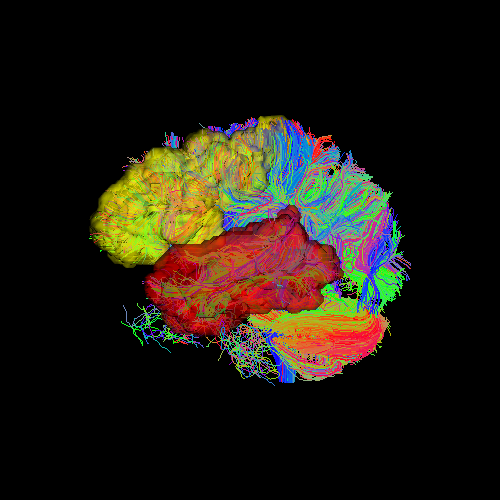

In [13]:
Image(kat.genren_AGG(long_sls[::100], aff=fa_aff, roi1=kkinclude[:,:,:,0], roi2=kkinclude[:,:,:,1]))

TEMPLATE INFORMATION

In [14]:
#template_basepath = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Base_CTRL'

In [15]:
track_list_path = 'WM_pathways_track_list.xlsx'
roi_matrix_path = 'WM_pathways_freesurfer_based_seg_EC_KMJmod.xlsx'
file_map_path = 'WM_pathways_recobundles_based_seg.xlsx'

In [16]:
import dipy.tracking.utils as dtu
import dipy.tracking.streamline as dts

In [17]:
from scipy.spatial.distance import cdist

#COPIED FROM PYAFQ
def _check_sl_with_inclusion(sl, include_rois, tol):
    """
    Helper function to check that a streamline is close to a list of
    inclusion ROIS.
    """
    dist = []
    for roi in include_rois:
        dist.append(cdist(sl, roi, 'euclidean'))
        if np.min(dist[-1]) > tol:
            # Too far from one of them:
            return False, []
    # Apparently you checked all the ROIs and it was close to all of them
    return True, dist


#COPIED FROM PYAFQ
def _check_sl_with_exclusion(sl, exclude_rois, tol):
    """ Helper function to check that a streamline is not too close to a list
    of exclusion ROIs.
    """
    for roi in exclude_rois:
        
        if np.min(cdist(sl, roi, 'euclidean')) < tol:
            return False
    # Either there are no exclusion ROIs, or you are not close to any:
    return True

#BEGIN NEW FUNCTIONS
# make dictionary from excel sheet
def build_volumetric_atlas_dict(track_name, roi_df):
    rois = roi_df[track_name]
    roi_groups = list(rois.value_counts().index)

    roi_dict = {}
    roi_dict['include'] = {}
    roi_dict['exclude'] = {}

    for i in roi_groups:
        if i > 0:
            roitype = 'include'
        elif i < 0:
            roitype = 'exclude'
        else:
            raise('UHOH')
        setname = 'set' + str(int(i))
        roi_dict[roitype][setname] = {}

        temp = roi_df[rois == i]
        for j, name in enumerate(temp['VOIS']):
            roi_dict[roitype][setname][name] = temp['aparc+aseg'].values[j]
    return roi_dict


# combine the rois into a single "NOT" exclusion and sets of "AND" inclusion
def combine_rois(mydict, apac):
    x, y, z = apac.shape
    
    include_coords = []
    exclude_coords = []
    
    for i, iset in enumerate(mydict['include'].keys()):
        include = np.zeros([x, y, z])
        for item in mydict['include'][iset].items():
            include += 1*(apac == item[-1])
        include_coords.append(np.array(np.where(include > 0)).T)
    for j, jset in enumerate(mydict['exclude'].keys()):
        for item in mydict['exclude'][jset].items():
            exclude_coords.append(np.array(np.where(apac == item[-1])).T)
    return include_coords, exclude_coords


# targeting script to target streamlines with ROIs
def check_targets(sls, include, exclude, tol):
    keep_sls=[]
    keep_array = np.zeros(len(sls))
    for i, sl in enumerate(sls):
        is_close_include, dist = _check_sl_with_inclusion(sl, include, tol)
        if is_close_include:
            is_close_exclude = _check_sl_with_exclusion(sl, exclude, tol)
            if is_close_exclude:
                keep_array[i] = 1
                keep_sls.append(sl)
    return keep_array, keep_sls


def calculate_volumetric_atlas_score(streamlines, csv_lookup_path,
                                     volumetric_atlas_path,
                                     track_list_path, file_map_path, aff, tol):
    # Here we assume the csv column names match track_list names
    roi_df = pd.read_excel(csv_lookup_path)
    track_list_df = pd.read_excel(track_list_path, index_col='column_name')
    track_list = list(track_list_df[track_list_df.segment_this > 0].index)[0:3]

    # Build dictionary of include/exclude rois and freesurfer codes from csv
    roi_dict = {}
    for tr in track_list:
        roi_dict[tr] = build_volumetric_atlas_dict(tr, roi_df=roi_df)
    atlas_data = nib.load(volumetric_atlas_path).get_data()

    streamlines_by_bundle = np.zeros([len(streamlines), len(track_list)])
    keep_bundles = []
    tgt_bundles = []
    for i, tr in enumerate(track_list):
        print(tr)
        xfmd_sls = dts.Streamlines(dtu.move_streamlines(streamlines,np.linalg.inv(aff)))
        include, exclude = combine_rois(roi_dict[tr], atlas_data)
        streamlines_by_bundle[:, i], test_bundle = check_targets(
            xfmd_sls, include, exclude, tol)
        ##test old way
        include2, exclude2 = kat.combine_rois(roi_dict[tr], atlas_data)
        test2 = kat.targetme(streamlines, include2, exclude2, aff)
        tgt_bundles.append(test2)
        
        #kat.genren_AGG(test2, roi1=include2[:,:,:,0], roi2=include2[:,:,:,1], showme=True)
        keep_bundles.append(test2)
        
        #kat.genren_AGG(streamlines[::100], roi1=include2[:,:,:,0], roi2=include2[:,:,:,1],  showme=True)
        #kat.genren_AGG(list(dtu.move_streamlines(test2,np.linalg.inv(aff))), roi1=include2[:,:,:,0], showme=True)
        #kat.genren_AGG(xfmd_sls, roi1=include2[:,:,:,0], showme=True)
    return streamlines_by_bundle, include2, exclude2, keep_bundles


In [18]:
track_list_df = pd.read_excel(track_list_path, index_col='column_name')
track_list = list(track_list_df[track_list_df.segment_this > 0].index)

In [19]:
subsampsls = long_sls[::10]

In [20]:
sxb_fs_atlas_score, incl, excl, bund = calculate_volumetric_atlas_score(subsampsls, 
                                                                  roi_matrix_path,
                                                                  apac_path,
                                                                  track_list_path, 
                                                                  file_map_path, 
                                                                  fa_aff,
                                                                  tol=1)

Left ASLANT
Left ARCUATE
Left SLF I


In [21]:
sxb_fs_atlas_score.shape

(78638, 3)

In [22]:
def get_bundle(sls, sls_by_bundles, showme=False):
    bundle_list = []
    for b in range(0,sls_by_bundles.shape[1]):
        mysls=[]
        for i,s in enumerate(sls):
            if sls_by_bundles[i,b] > 0:
                mysls.append(s)
        if showme:
            try:
                kat.genren_AGG(mysls, showme=True)
            except:
                print('uhoh')
        bundle_list.append(mysls)
    return bundle_list

In [ ]:
bundlist = get_bundle(subsampsls, sxb_fs_atlas_score, showme=False)

In [64]:
from dipy.viz import window, actor
def make_spin_snapshots(ren, Nframes=25, size=(200,200), savename='temp'):
    increment = int(360/Nframes)
    for i in range(0, Nframes):
        ren.yaw(increment)
        window.record(ren, out_path=savename + str(i)+'.png', size=size)
    return savename

In [65]:
def qc_multibundle_ren(bundle_list, showme=False):
    ren = window.Renderer()
    colormap = actor.create_colormap(np.arange(len(bundle_list)+1))

    window.clear(ren)
    ren.set_camera(position=(-606.93, -153.23, 28.70),
                        focal_point=(2.78, 11.06, 15.66),
                        view_up=(0, 0, 1))
    ren.SetBackground(1, 1, 1)
    for i,clusters in enumerate(bundle_list):
        ren.add(actor.streamtube(clusters, colormap[i], linewidth=0.4))
    if showme:
        window.show(ren)
    return ren

In [66]:
def qc_bundle_ren(bundle, showme=False):
    ren = window.Renderer()
    ren.SetBackground(1, 1, 1)

    window.clear(ren)
    ren.set_camera(position=(-606.93, -153.23, 28.70),
                   focal_point=(2.78, 11.06, 15.66),
                   view_up=(0, 0, 1))

    ren.add(actor.streamtube(bundle, linewidth=0.4))
    if showme:
        window.show(ren)
    return ren

In [67]:
from PIL import Image as pilim
from PIL import ImageSequence

def make_mosaic(input_base_name, output_base_name='temp', mo_height=1000, mo_width=1000):
    im=pilim.open(input_base_name+str(0)+'.png')
    panel_width, panel_height = im.size
    mosaic = pilim.new('RGB', (mo_width,mo_height))
    hop = 0
    for j in range(0,mo_height,panel_height):
        for i in range(0,mo_width,panel_width):
            im=pilim.open(input_base_name+str(hop)+'.png')
            mosaic.paste(im, (i,j))
            hop+=1
    save_name = output_base_name+'_mosaic.png'
    mosaic.save(save_name)
    return save_name

In [68]:
import tempfile
def qc_bundle_ren(bundle, showme=False):
    ren = window.Renderer()
    ren.SetBackground(1, 1, 1)

    window.clear(ren)
    ren.set_camera(position=(-606.93, -153.23, 28.70),
                   focal_point=(2.78, 11.06, 15.66),
                   view_up=(0, 0, 1))
    ren.add(actor.streamtube(bundle, linewidth=0.3))
    if showme:
        window.show(ren)
    return ren


def qc_multibundle_ren(bundle_list, showme=False):
    ren = window.Renderer()
    colormap = actor.create_colormap(np.arange(len(bundle_list) + 1))

    window.clear(ren)
    ren.set_camera(position=(-606.93, -153.23, 28.70),
                   focal_point=(2.78, 11.06, 15.66),
                   view_up=(0, 0, 1))
    ren.SetBackground(1, 1, 1)
    for i, bundle in enumerate(bundle_list):
        ren.add(actor.streamtube(bundle, colormap[i], linewidth=0.3))
    if showme:
        window.show(ren)
    return ren


def make_spin_snapshots(ren, output_path, Nframes=25, size=(200, 200)):
    png_paths = []
    increment = int(360 / Nframes)
    for i in range(0, Nframes):
        pngpath = os.path.join(output_path, str(i) + '.png')
        ren.yaw(increment)
        window.record(ren, out_path=pngpath, size=size)
        png_paths.append(pngpath)
    return png_paths


def make_mosaic(ren, output_path, Nframes=25, patch_size=(200, 200),
                mosaic_height=1000, mosaic_width=1000):
    tdir = tempfile.gettempdir()
    png_paths = make_spin_snapshots(ren, tdir, Nframes, patch_size)
    im = pilim.open(png_paths[0])
    panel_width, panel_height = im.size
    mosaic = pilim.new('RGB', (mosaic_width, mosaic_height))
    hop = 0
    for j in range(0, mosaic_height, panel_height):
        for i in range(0, mosaic_width, panel_width):
            im = pilim.open(png_paths[hop])
            mosaic.paste(im, (i, j))
            hop += 1
    mosaic.save(output_path)
    return output_path

In [22]:
kren = qc_bundle_ren(bundlist[0])
kren2 = qc_multibundle_ren(bundlist)

NameError: name 'bundlist' is not defined

In [ ]:
Image(make_mosaic(kren, 'temp.png'))

In [ ]:
Image(make_mosaic(kren2, './temp2.png'))

# Part II

In [33]:
def build_bundle_atlas_dict(bundle_atlas_directory, whole_brain_streamline, name_correspondence_df):
    bundles = glob(bundle_atlas_directory+'/*.trk')
    bundle_dict={}
    for bpath in bundles:
        basename = os.path.basename(bpath)
        bname = list(name_correspondence_df[name_correspondence_df['file_name']==basename]['column_name'])[0]
        prune = list(name_correspondence_df[name_correspondence_df['file_name']==basename]['pruning_thresh'])[0]

        bundle_dict[bname] = {}
        bundle_dict[bname]['path'] = bpath
        bundle_dict[bname]['pruning_threshold'] = prune
    return bundle_dict

def calculate_bundle_atlas_score(bundle_atlas_dict, whole_brain, mni2sub_xfm,
                                 cluster_thr=5, pruning_thr=10,
                                 reduction_thr=10):
    cluster_map = qbx_with_merge(whole_brain, thresholds=[40, 25, 20, 10])
    rb = RecoBundles(whole_brain, cluster_map=cluster_map,
                     cluster_thr=cluster_thr)
    track_list = bundle_atlas_dict.keys()
    print(track_list)
    streamlines_by_bundle = np.zeros([len(whole_brain), len(track_list)])
    for i, b in enumerate(track_list):
        print(b)
        bundle_xfmd = dtu.move_streamlines(bundle_atlas_dict[b], aff)
        b_atlassp, labels, b_subsp = rb.recognize(model_bundle=bundle_xfmd,
                                                  model_clust_thr=5.,
                                                  reduction_thr=10,
                                                  pruning_thr=pruning_thr)
        streamlines_by_bundle[:, i] = labels
    return streamlines_by_bundle

In [34]:
bundle_atlas_path = '/Users/kesshijordan/Desktop/Kesh_Templates/TRIO_Children/ccipt5/'
whole_brain_atlas_path = '/Users/kesshijordan/ref_data/Atlas_in_MNI_Space_16_bundles/whole_brain/whole_brain_MNI.trk'
bundle_template_name_correspondence = 'WM_pathways_recobundles_based_seg_cci.xlsx'
name_correspondence_df = pd.read_excel(bundle_template_name_correspondence)

In [35]:
bundle_atlas_path = '/Users/kesshijordan/ref_data/Atlas_in_MNI_Space_16_bundles/bundles/'
whole_brain_atlas_path = '/Users/kesshijordan/ref_data/Atlas_in_MNI_Space_16_bundles/whole_brain/whole_brain_MNI.trk'
bundle_template_name_correspondence = 'pyAFQ_recobundles_lookup.xlsx'
track_this = 'pyAFQ_track_this_list.xlsx'
name_correspondence_df = pd.read_excel(bundle_template_name_correspondence)

In [36]:
name_correspondence_df.head()

,column_name,file_name,pruning_thresh,pyAFQ_name
0,Left ASLANT,NaN,10,NaN
1,Left ARCUATE,AF_L.trk,10,NaN
2,Left SLF I,NaN,10,NaN
3,Left SLF II,NaN,10,NaN
4,Left SLF III,NaN,10,NaN


In [37]:
mydict = build_bundle_atlas_dict(bundle_atlas_path, whole_brain_atlas_path, name_correspondence_df)

In [38]:
mni_tg, mni_hdr = kat.loadtgm_newapi(whole_brain_atlas_path)
mni_sls = mni_tg.streamlines

In [39]:
bundle_atlas_path

'/Users/kesshijordan/ref_data/Atlas_in_MNI_Space_16_bundles/bundles/'

In [40]:
temp_tg, temp_hdr = kat.loadtgm_newapi(os.path.join(bundle_atlas_path, 'IFOF_L.trk'))
temp_sls = temp_tg.streamlines

In [41]:
moved_temp2case, xfm_temp2case, qbc1_temp2pcase, qbc2_temp2case = kat.rough_reg(long_sls[::100], mni_sls)

Static streamlines size 7864
Moving streamlines size 144678
Static streamlines after length reduction 6345
Moving streamlines after length reduction 123874
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 32
QB moving centroids size 231
SLR finished in  2.116 seconds.
SLR iterations: 80 


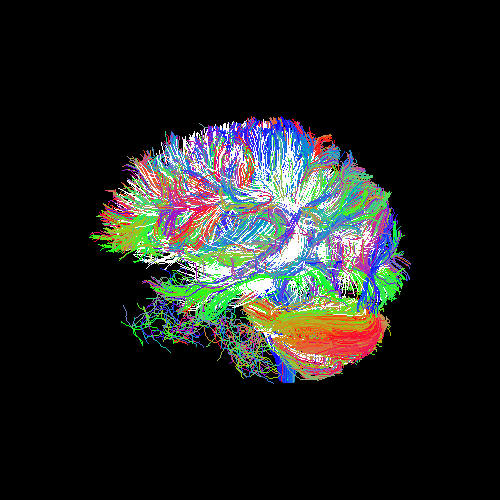

In [42]:
Image(kat.genren_AGG(long_sls[::100],moved_temp2case[::100]))

In [74]:
from dipy.segment.clustering import qbx_and_merge
from dipy.segment.bundles import RecoBundles

def calculate_bundle_atlas_score(bundle_atlas_dict, whole_brain, template2sub_xfm, 
                                 cluster_thr=5, pruning_thr=10,
                                 reduction_thr=10):
    
    wb_arrayseq = nib.streamlines.ArraySequence(whole_brain)
    
    cluster_map = qbx_and_merge(whole_brain, thresholds=[40, 25, 20, 10], verbose=False)
    
    rb = RecoBundles(wb_arrayseq, cluster_map=cluster_map, verbose=False)
    track_list = list(bundle_atlas_dict.keys())
    streamlines_by_bundle = np.zeros([len(whole_brain), len(track_list)])
    for i, b in enumerate(track_list):
        print(b)
        b_tg, b_hdr = kat.loadtgm_newapi(bundle_atlas_dict[b]['path'])
        
        bundle_xfmd = b_tg.copy().apply_affine(template2sub_xfm).streamlines
        
        b_atlassp, labels, b_subsp = rb.recognize(model_bundle=bundle_xfmd,
                                                  model_clust_thr=5.,
                                                  reduction_thr=10,
                                                  pruning_thr=pruning_thr)
        for l in labels:
            streamlines_by_bundle[l, i] = 1

    return streamlines_by_bundle

In [75]:
bundle_slsxbundles = calculate_bundle_atlas_score(mydict, long_sls[::10], xfm_temp2case,cluster_thr=5)

Right CST
Right IFOF
Left Cingulum
Left Fornix
Right Uncinate
Middle Cerebellar Peduncles
Right ARCUATE
 You have no neighbor streamlines... No bundle recognition
Middle Corpus Callosum
Right Fornix
Left Uncinate
Left ARCUATE
Forceps Major
Forceps Minor
Left CST
Left IFOF
Right Cingulum


In [77]:
bundlist = get_bundle(long_sls[::10], bundle_slsxbundles, showme=True)

uhoh


In [79]:
tracklist = list(mydict.keys())

In [ ]:
for i,b in enumerate(abund):
    print(tracklist[i])
    try:
        aa = qc_bundle_ren(abund[i])
        make_mosaic(aa, tracklist[i]+'_mosaic.png')
    except:
        print('uhoh')

Right CST
uhoh
Right IFOF
uhoh
Left Cingulum
uhoh
Left Fornix
uhoh
Right Uncinate
uhoh
Middle Cerebellar Peduncles
uhoh
Right ARCUATE
uhoh
Middle Corpus Callosum
uhoh
Right Fornix
uhoh
Left Uncinate
Left ARCUATE
Forceps Major
Forceps Minor
Left CST
